### RQ 2: Can we identify patterns in the prompts developers use when interacting with ChatGPT, and do these patterns correlate with the success of issue resolution?

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Paths to JSON files
hacker_news_json_path = "20230727_195816_hn_sharings.json"
issues_json_path = "20230727_195941_issue_sharings.json"

# Load and normalize the hacker_news JSON file
data_hacker_news = pd.read_json(hacker_news_json_path)
df_hacker_news = pd.json_normalize(data_hacker_news["Sources"])

# Extract prompts from ChatgptSharing
def extract_prompts(chatgpt_sharing):
    if not isinstance(chatgpt_sharing, list): 
        return []
    return [conv.get('Prompt', '') for item in chatgpt_sharing for conv in item.get('Conversations', []) if 'Prompt' in conv]

df_hacker_news["Prompts"] = df_hacker_news["ChatgptSharing"].apply(extract_prompts)
df_hacker_news = df_hacker_news.explode("Prompts").dropna(subset=["Prompts"])

# Vectorize prompts
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df_hacker_news["Prompts"])

# Cluster prompts into patterns
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_hacker_news["PromptCluster"] = kmeans.fit_predict(X)

# Review sample prompts for each cluster
pd.set_option('display.max_colwidth', None)
for cluster_id, cluster_df in df_hacker_news.groupby("PromptCluster"):
    print(f"Sample Prompts for Cluster {cluster_id}:")
    print(cluster_df["Prompts"].head(5))
    print()

Sample Prompts for Cluster 0:
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [2]:
# Manual mapping of cluster IDs to meaningful names
manual_cluster_names = {
    0: "Creative and Writing Requests",
    1: "Repetitive Text Requests",
    2: "File and Code Requests",
    3: "Numeric and Fact-Based Requests",
    4: "Programming and Debugging Requests"
}

df_hacker_news["PromptCluster"] = df_hacker_news["PromptCluster"].map(manual_cluster_names)

# Function to extract URLs from ChatgptSharing
def extract_urls(chatgpt_sharing):
    if not isinstance(chatgpt_sharing, list):
        return []
    return [item.get("URL", "") for item in chatgpt_sharing if "URL" in item]

# Extract URLs in hacker_news and issue files
df_hacker_news["ChatgptURLs"] = df_hacker_news["ChatgptSharing"].apply(extract_urls)
data_issues = pd.read_json(issues_json_path)
df_issues = pd.json_normalize(data_issues["Sources"])
df_issues["ChatgptURLs"] = df_issues["ChatgptSharing"].apply(extract_urls)

# Flatten the extracted URLs by exploding the lists
df_hacker_news = df_hacker_news.explode("ChatgptURLs").dropna(subset=["ChatgptURLs"])
df_issues = df_issues.explode("ChatgptURLs").dropna(subset=["ChatgptURLs"])

# Merge using ChatgptURLs
df_combined = pd.merge(
    df_hacker_news,
    df_issues,
    left_on="ChatgptURLs",
    right_on="ChatgptURLs",
    how="inner"
)

# Create a 'Resolved' column for issues that contain 0 or 1 for all the rows
df_combined["Resolved"] = df_combined["State"] == "CLOSED"

# Calculate average prompt length by cluster
df_combined["PromptLength"] = df_combined["Prompts"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
avg_prompt_length = df_combined.groupby("PromptCluster")["PromptLength"].mean()
print("Average Prompt Length by Cluster:")
print(avg_prompt_length)

# Correlation of Prompt Length with Resolution Success
correlation = df_combined.groupby("PromptCluster")["Resolved"].mean()
print("\nCorrelation of Prompt Patterns with Resolution Success:")
print(correlation)

# Prompt Complexity Analysis (Length, Unique Words, Sentences)
def prompt_complexity_metrics(prompt):
    words = prompt.split()
    num_sentences = prompt.count('.') + prompt.count('!') + prompt.count('?')
    return len(words), len(set(words)), num_sentences

complexity_metrics = df_combined["Prompts"].dropna().apply(prompt_complexity_metrics)
complexity_df = pd.DataFrame(complexity_metrics.tolist(), columns=["WordCount", "UniqueWords", "SentenceCount"], index=df_combined["Prompts"].dropna().index)

# Add complexity metrics to the combined DataFrame
df_combined = pd.concat([df_combined, complexity_df], axis=1)

# Calculate averages for successful and unsuccessful prompts
success_metrics = df_combined[df_combined["Resolved"] == True][["WordCount", "UniqueWords", "SentenceCount"]].mean()
failure_metrics = df_combined[df_combined["Resolved"] == False][["WordCount", "UniqueWords", "SentenceCount"]].mean()

print("\nPrompt Complexity Metrics (Successful Prompts):")
print(success_metrics)

print("\nPrompt Complexity Metrics (Unsuccessful Prompts):")
print(failure_metrics)

# Prompt Diversity Analysis (Unique Prompts per Cluster)
unique_prompts_per_cluster = df_combined.groupby("PromptCluster")["Prompts"].nunique()
print("\nUnique Prompts per Cluster:")
print(unique_prompts_per_cluster)

# Keyword Analysis
successful_prompts = df_combined[df_combined["Resolved"] == True]["Prompts"]
unsuccessful_prompts = df_combined[df_combined["Resolved"] == False]["Prompts"]

# Tokenize and count top keywords for successful and unsuccessful prompts
def get_top_keywords(prompts, top_n=10):
    words = [word for prompt in prompts.dropna() for word in prompt.split()]
    return Counter(words).most_common(top_n)

top_successful_keywords = get_top_keywords(successful_prompts)
top_unsuccessful_keywords = get_top_keywords(unsuccessful_prompts)

print("\nTop Keywords in Successful Prompts:")
print(top_successful_keywords)
print("\nTop Keywords in Unsuccessful Prompts:")
print(top_unsuccessful_keywords)

Average Prompt Length by Cluster:
PromptCluster
Creative and Writing Requests         20.250000
File and Code Requests                36.290323
Programming and Debugging Requests    71.857143
Repetitive Text Requests              37.774194
Name: PromptLength, dtype: float64

Correlation of Prompt Patterns with Resolution Success:
PromptCluster
Creative and Writing Requests         0.250000
File and Code Requests                0.193548
Programming and Debugging Requests    0.857143
Repetitive Text Requests              0.064516
Name: Resolved, dtype: float64

Prompt Complexity Metrics (Successful Prompts):
WordCount        105.625
UniqueWords       61.500
SentenceCount      8.375
dtype: float64

Prompt Complexity Metrics (Unsuccessful Prompts):
WordCount        20.836066
UniqueWords      17.622951
SentenceCount     2.393443
dtype: float64

Unique Prompts per Cluster:
PromptCluster
Creative and Writing Requests          7
File and Code Requests                25
Programming and Debuggin

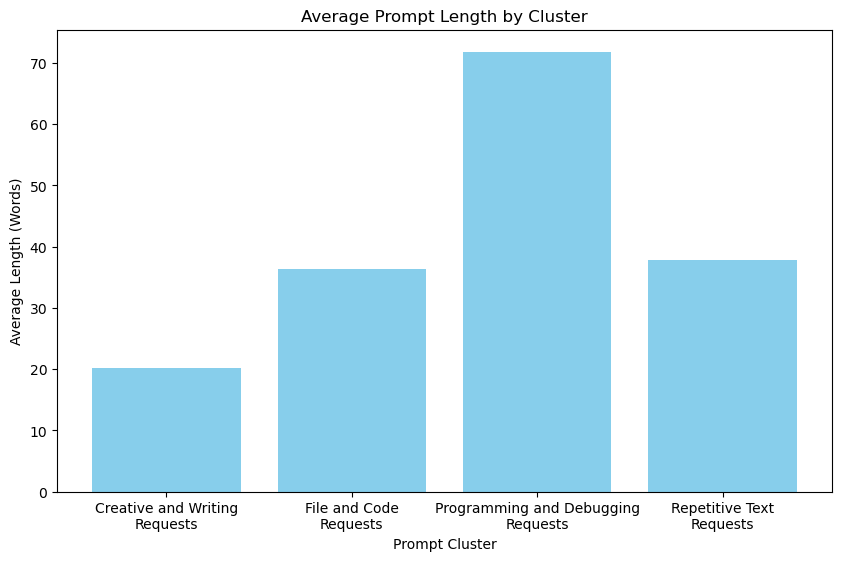

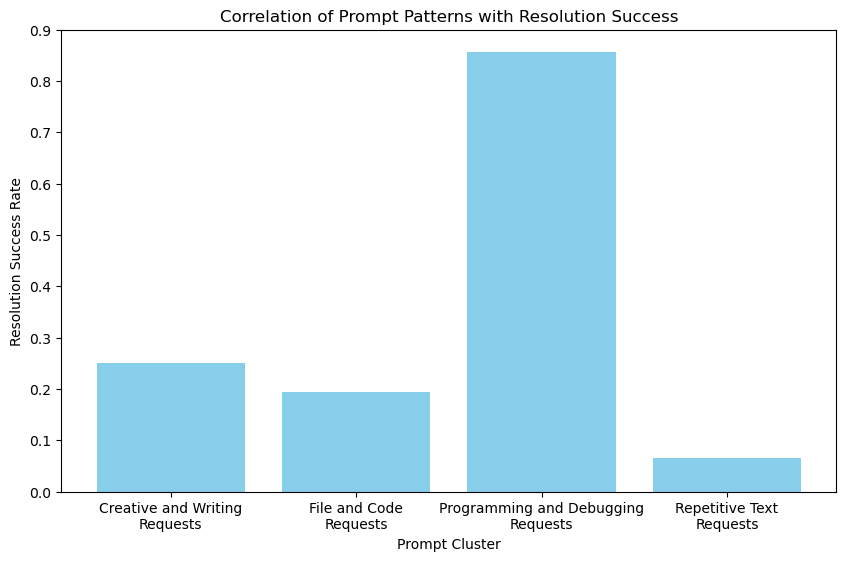

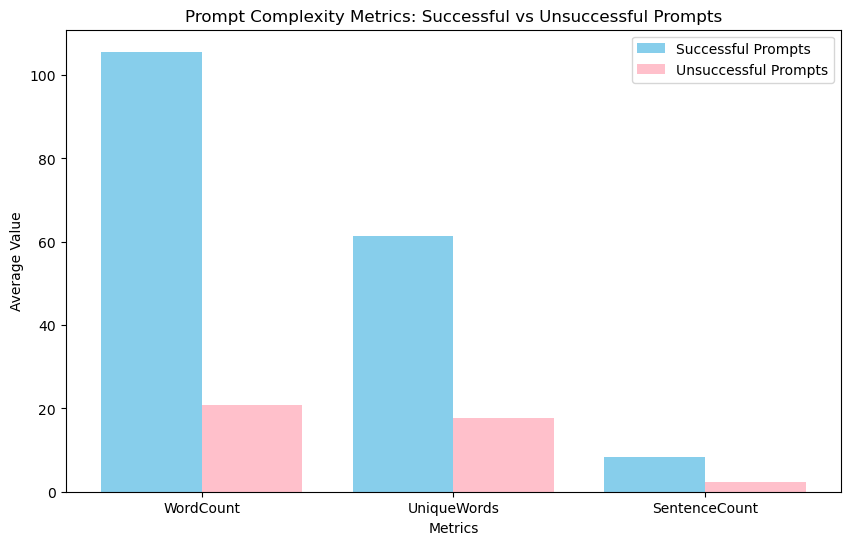

In [3]:
# Modify labels for two-line display
custom_labels = {
    "Creative and Writing Requests": "Creative and Writing\nRequests",
    "Repetitive Text Requests": "Repetitive Text\nRequests",
    "File and Code Requests": "File and Code\nRequests",
    "Numeric and Fact-Based Requests": "Numeric and Fact-Based\nRequests",
    "Programming and Debugging Requests": "Programming and Debugging\nRequests"
}

# Update indices with custom labels
avg_prompt_length.index = avg_prompt_length.index.map(custom_labels)
correlation.index = correlation.index.map(custom_labels)

# Visualization
plt.figure(figsize=(10, 6))

# Average Prompt Length by Cluster
plt.bar(avg_prompt_length.index, avg_prompt_length.values, color='skyblue')
plt.title("Average Prompt Length by Cluster")
plt.xlabel("Prompt Cluster")
plt.ylabel("Average Length (Words)")
plt.xticks(rotation=0)
plt.show()

# Correlation of Prompt Patterns with Resolution Success
plt.figure(figsize=(10, 6))
plt.bar(correlation.index, correlation.values, color='skyblue')
plt.title("Correlation of Prompt Patterns with Resolution Success")
plt.xlabel("Prompt Cluster")
plt.ylabel("Resolution Success Rate")
plt.xticks(rotation=0)
plt.show()

# Prompt Complexity Metrics Comparison
metrics = ['WordCount', 'UniqueWords', 'SentenceCount']
success_values = success_metrics.values
failure_values = failure_metrics.values
x = np.arange(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, success_values, 0.4, label='Successful Prompts', color='skyblue')
plt.bar(x + 0.2, failure_values, 0.4, label='Unsuccessful Prompts', color='pink')
plt.xticks(x, metrics)
plt.title("Prompt Complexity Metrics: Successful vs Unsuccessful Prompts")
plt.xlabel("Metrics")
plt.ylabel("Average Value")
plt.legend()
plt.show()

#### Insights:
- Patterns in developer prompts are strongly correlated with resolution success.
- Key factors influencing success are prompt length, complexity, clarity, and specificity.
- Clusters like "Programming and Debugging Requests" perform well due to their focused and detailed nature, while generic or repetitive prompts perform poorly.

In [4]:
# Automatic naming for clusters based on top keywords
def automatic_cluster_naming(prompts, n_keywords=5):
    keywords = [word for prompt in prompts.dropna() for word in prompt.split()]
    common_keywords = Counter(keywords).most_common(n_keywords)
    return "Top Keywords: " + ", ".join([kw[0] for kw in common_keywords])

# Generate automatic names for each cluster
automatic_names = {}
for cluster, group in df_combined.groupby("PromptCluster"):
    cluster_prompts = group["Prompts"]
    automatic_names[cluster] = automatic_cluster_naming(cluster_prompts)

print("\nAutomatically Generated Cluster Names:")
for cluster, name in automatic_names.items():
    print(f"Cluster '{cluster}': {name}")


Automatically Generated Cluster Names:
Cluster 'Creative and Writing Requests': Top Keywords: and, to, do, you, the
Cluster 'File and Code Requests': Top Keywords: ||, as, the, ', it
Cluster 'Programming and Debugging Requests': Top Keywords: =, if, and, that, the
Cluster 'Repetitive Text Requests': Top Keywords: the, of, you, text, TEXT,
